In [14]:
import itertools
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6

In [33]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=1):
    
    if useTrainCV:

        xgb_param = alg.get_xgb_params()
        #xgb_param['num_class'] =len(np.unique(dtrain['Class']))
        
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc',
         early_stopping_rounds=early_stopping_rounds)#, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Class'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Class'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Class'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

# multi-class

In [4]:
data = pd.read_csv('C:/Users/MAX/Desktop/LargeTrain.csv')
train = pd.DataFrame(data)
a= lambda x: x-1
train['Class']=train['Class'].apply(a)
train

,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,LONG,BOOL,...,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107,Class
0,3,3,689,18,6,890,6,39,17,88,...,35148,8687,55835,9078,21355,56302,10380,171979,162674,1
1,3,3,583,15,5,1574,5,6,7,30,...,571,718,1762,642,1820,1675,1100,7702,6551,7
2,3,4,2796,15,5,625,5,58,11,152,...,29872,16910,31708,9000,17586,30719,30062,55331,12946,8
3,3,3,373,27,9,615,9,16,10,34,...,10742,9755,26992,9069,24885,27108,13219,122247,98621,8
4,3,3,77,12,4,66,4,3,0,5,...,962,1307,3119,1172,3522,3245,2001,15501,11864,0
5,3,3,86,6,2,6,2,0,0,1,...,474,561,1389,581,1537,1293,1275,7048,6164,5
6,3,3,469,21,7,291,7,43,15,82,...,33452,15370,63663,15581,42067,63996,21127,221716,176170,1
7,3,3,2090,21,7,4035,7,17,8,40,...,1378,1901,4588,2004,5550,4494,2803,21692,18786,1
8,3,3,691,18,6,597,6,30,16,61,...,43370,13748,66715,14946,39350,71793,18663,219223,167493,1
9,6,6,229,0,8,526,0,11,1,13,...,1031,1076,3040,1097,3216,2985,1577,12860,6860,5



Model Report
Accuracy : 0.9967


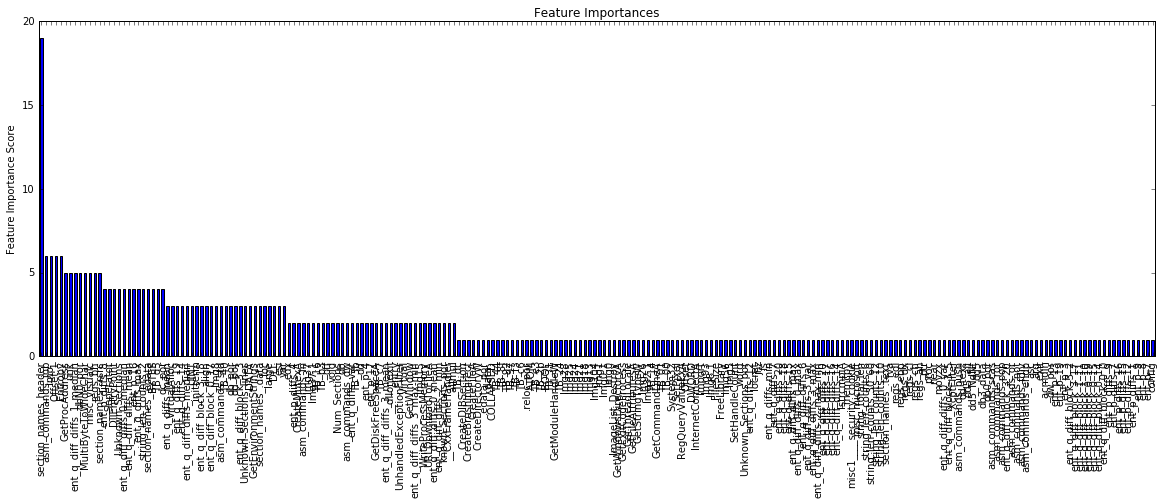

In [30]:
#For multiclass
target='Class'
predictors = [x for x in train.columns if x not in [target]]
xgb0 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb0, train, predictors)

In [5]:
target='Class'
predictors = [x for x in train.columns if x not in [target]]
param_test1 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.97045, std: 0.00776, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.97027, std: 0.00693, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.96972, std: 0.00515, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.96852, std: 0.00737, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.96797, std: 0.00604, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.97939, std: 0.00341, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.97800, std: 0.00453, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.97644, std: 0.00279, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.97690, std: 0.00469, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.97561, std: 0.00386, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.98334, std: 0.00233, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.98233, std: 0.00323, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.97939, std: 0.00223, params: {

In [9]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2,n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.98564, std: 0.00212, params: {'gamma': 0.0},
  mean: 0.98564, std: 0.00212, params: {'gamma': 0.1},
  mean: 0.98564, std: 0.00212, params: {'gamma': 0.2},
  mean: 0.98574, std: 0.00217, params: {'gamma': 0.3},
  mean: 0.98574, std: 0.00217, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.98573622206088296)

In [10]:
param_test3 = {
'subsample':[i/100.0 for i in range(60,100)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1, max_depth=9,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3,n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.98399, std: 0.00313, params: {'subsample': 0.6},
  mean: 0.98408, std: 0.00284, params: {'subsample': 0.61},
  mean: 0.98436, std: 0.00289, params: {'subsample': 0.62},
  mean: 0.98481, std: 0.00254, params: {'subsample': 0.63},
  mean: 0.98445, std: 0.00191, params: {'subsample': 0.64},
  mean: 0.98454, std: 0.00224, params: {'subsample': 0.65},
  mean: 0.98426, std: 0.00278, params: {'subsample': 0.66},
  mean: 0.98463, std: 0.00297, params: {'subsample': 0.67},
  mean: 0.98546, std: 0.00329, params: {'subsample': 0.68},
  mean: 0.98500, std: 0.00244, params: {'subsample': 0.69},
  mean: 0.98546, std: 0.00272, params: {'subsample': 0.7},
  mean: 0.98574, std: 0.00260, params: {'subsample': 0.71},
  mean: 0.98527, std: 0.00231, params: {'subsample': 0.72},
  mean: 0.98491, std: 0.00228, params: {'subsample': 0.73},
  mean: 0.98436, std: 0.00271, params: {'subsample': 0.74},
  mean: 0.98482, std: 0.00225, params: {'subsample': 0.75},
  mean: 0.98555, std: 0.00204, params: {'s

In [11]:
param_test4 = {
 'colsample_bytree':[i/100.0 for i in range(60,100)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1, max_depth=9,
 min_child_weight=1, gamma=0.3, subsample=0.92, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4,n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.98610, std: 0.00313, params: {'colsample_bytree': 0.6},
  mean: 0.98619, std: 0.00327, params: {'colsample_bytree': 0.61},
  mean: 0.98601, std: 0.00340, params: {'colsample_bytree': 0.62},
  mean: 0.98592, std: 0.00316, params: {'colsample_bytree': 0.63},
  mean: 0.98592, std: 0.00316, params: {'colsample_bytree': 0.64},
  mean: 0.98619, std: 0.00340, params: {'colsample_bytree': 0.65},
  mean: 0.98647, std: 0.00304, params: {'colsample_bytree': 0.66},
  mean: 0.98712, std: 0.00201, params: {'colsample_bytree': 0.67},
  mean: 0.98712, std: 0.00201, params: {'colsample_bytree': 0.68},
  mean: 0.98712, std: 0.00188, params: {'colsample_bytree': 0.69},
  mean: 0.98721, std: 0.00202, params: {'colsample_bytree': 0.7},
  mean: 0.98702, std: 0.00226, params: {'colsample_bytree': 0.71},
  mean: 0.98721, std: 0.00218, params: {'colsample_bytree': 0.72},
  mean: 0.98730, std: 0.00213, params: {'colsample_bytree': 0.73},
  mean: 0.98767, std: 0.00222, params: {'colsample_bytree': 0.74

In [13]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2,0.1,1,100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1, max_depth=9,
 min_child_weight=1, gamma=0.3, subsample=0.92, colsample_bytree=0.93,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5,n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.98997, std: 0.00089, params: {'reg_alpha': 1e-05},
  mean: 0.98997, std: 0.00089, params: {'reg_alpha': 0.01},
  mean: 0.99006, std: 0.00103, params: {'reg_alpha': 0.1},
  mean: 0.98997, std: 0.00168, params: {'reg_alpha': 1},
  mean: 0.97598, std: 0.00307, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.99006234457085929)

In [14]:
param_test6 = {
 'reg_alpha':[0,0.01,0.05,0.1,0.5]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1, max_depth=9,
 min_child_weight=1, gamma=0.3, subsample=0.92, colsample_bytree=0.93,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6,n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.98997, std: 0.00089, params: {'reg_alpha': 0},
  mean: 0.98997, std: 0.00089, params: {'reg_alpha': 0.01},
  mean: 0.99006, std: 0.00103, params: {'reg_alpha': 0.05},
  mean: 0.99006, std: 0.00103, params: {'reg_alpha': 0.1},
  mean: 0.98951, std: 0.00147, params: {'reg_alpha': 0.5}],
 {'reg_alpha': 0.05},
 0.99006234457085929)


Model Report
Accuracy : 0.999


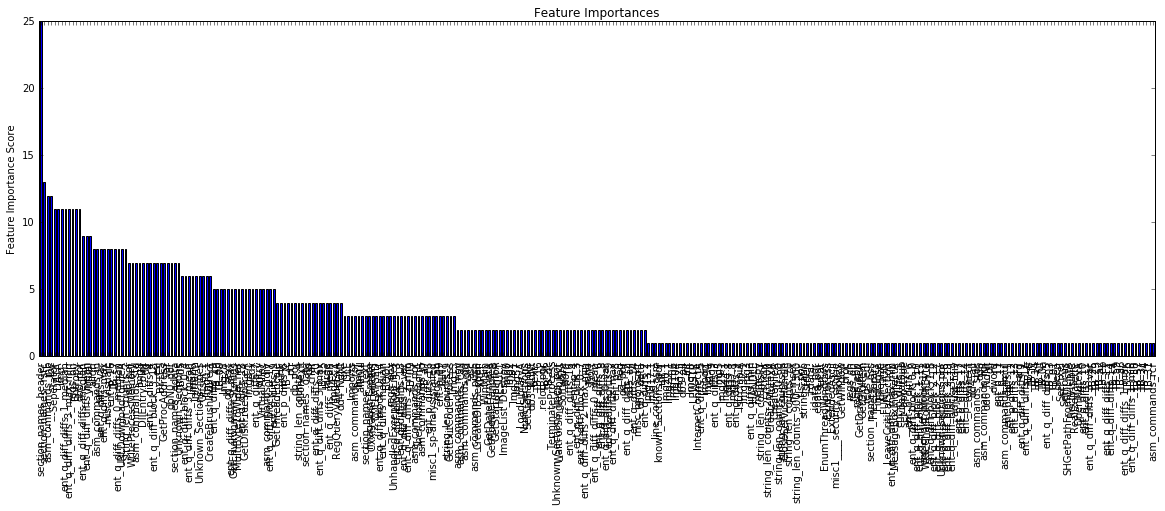

In [31]:
#For multiclass
target='Class'
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.92,
 colsample_bytree=0.93,
 reg_alpha=0.05,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

Confusion matrix , without normalization


<function matplotlib.pyplot.show>

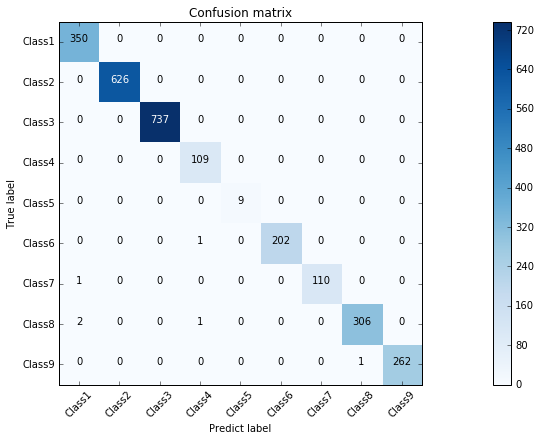

In [17]:
def plot_confusion_matrix(cm , classes , normalize=False , title='Confusion matrix' , cmap=plt.cm.Blues):
    plt.imshow(cm , interpolation='nearest' , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks , classes , rotation=45)
    plt.yticks(tick_marks , classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    else:
        print('Confusion matrix , without normalization')
    #print(cm)
    
    thresh = cm.max()/2.
    for i , j in itertools.product(range(cm.shape[0]) , range(cm.shape[1])):
        plt.text(j , i , cm[i,j] , horizontalalignment='center' , color='white' if cm[i,j]>thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    
class_name = ['Class' + str(x) for x in range(1,10)]
target='Class'
predictors = [x for x in train.columns if x not in [target]]
X = data[predictors]
y = data[target]

X_train , X_test , y_train , y_test = train_test_split(X, y , random_state=0)
clf = XGBClassifier(max_depth=9,min_child_weight=1,gamma=0.3,subsample=0.92,colsample_bytree=0.93,reg_alpha=0.05)
clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

cnf_matrix = confusion_matrix(y_test , y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_name,title='Confusion matrix')
plt.show

# binary

In [38]:
data = pd.read_csv('C:/Users/MAX/Desktop/LargeTrain.csv')
train2 = pd.DataFrame(data)
t= lambda x: x-1
train2['Class']=train2['Class'].apply(t)
a=train2.ix[:,'Class']>1
train2['Class'][a]=0
train2

C:\Users\MAX\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,LONG,BOOL,...,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107,Class
0,3,3,689,18,6,890,6,39,17,88,...,35148,8687,55835,9078,21355,56302,10380,171979,162674,1
1,3,3,583,15,5,1574,5,6,7,30,...,571,718,1762,642,1820,1675,1100,7702,6551,0
2,3,4,2796,15,5,625,5,58,11,152,...,29872,16910,31708,9000,17586,30719,30062,55331,12946,0
3,3,3,373,27,9,615,9,16,10,34,...,10742,9755,26992,9069,24885,27108,13219,122247,98621,0
4,3,3,77,12,4,66,4,3,0,5,...,962,1307,3119,1172,3522,3245,2001,15501,11864,0
5,3,3,86,6,2,6,2,0,0,1,...,474,561,1389,581,1537,1293,1275,7048,6164,0
6,3,3,469,21,7,291,7,43,15,82,...,33452,15370,63663,15581,42067,63996,21127,221716,176170,1
7,3,3,2090,21,7,4035,7,17,8,40,...,1378,1901,4588,2004,5550,4494,2803,21692,18786,1
8,3,3,691,18,6,597,6,30,16,61,...,43370,13748,66715,14946,39350,71793,18663,219223,167493,1
9,6,6,229,0,8,526,0,11,1,13,...,1031,1076,3040,1097,3216,2985,1577,12860,6860,0


In [6]:
import random
#num=random.sample(range(len(temp0['Class'])), 2500)
temp=train2[train2.ix[:,'Class']==0]
temp0=temp.ix[random.sample(temp.index, 2500)]
temp1=train2[train2.ix[:,'Class']==1]
frames=[temp0,temp1]
train2=pd.concat(frames)
train2

,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,LONG,BOOL,...,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107,Class
6355,3,4,1966,12,4,613,4,94,39,287,...,30074,17467,31324,9163,17880,31107,30660,54330,11689,0
9075,3,3,524,15,5,1574,5,6,7,30,...,581,704,1722,649,1819,1706,1181,7765,6462,0
5454,3,3,529,27,9,1032,9,2,0,25,...,12608,11192,31362,9222,25595,31657,18003,126035,77767,0
227,3,4,1475,27,9,757,9,144,12,159,...,3668,2462,4642,1287,3139,4383,3854,9915,3129,0
10378,3,3,16,12,4,17,4,9,0,16,...,5797,5936,15989,6011,15960,15811,7893,71446,68540,0
10669,3,3,133,12,4,28,4,8,0,11,...,6045,5903,16087,5968,15660,15892,7806,72040,68453,0
8627,3,3,1333,0,0,4,0,0,0,1,...,2051,2193,5410,2132,6261,5488,4271,26464,23951,0
10336,3,4,3369,18,6,1441,6,67,8,165,...,3639,2372,4992,1601,3593,4905,4050,12968,5438,0
9035,5,5,2523,0,4,79,0,11,1,16,...,3833,4184,10829,4127,11578,10670,6507,51168,35889,0
6419,6,6,34363,0,16,26838,0,140,25,181,...,5850,6843,18409,6081,18483,17125,10647,79486,52756,0


In [8]:
target='Class'
predictors = [x for x in train2.columns if x not in [target]]
param_test7 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test7,n_jobs=4,iid=False, cv=5)
gsearch7.fit(train2[predictors],train2[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.99839, std: 0.00080, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.99839, std: 0.00080, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.99859, std: 0.00049, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.99859, std: 0.00080, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.99759, std: 0.00080, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.99839, std: 0.00080, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.99839, std: 0.00080, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.99859, std: 0.00049, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.99859, std: 0.00080, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.99759, std: 0.00080, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.99839, std: 0.00080, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.99839, std: 0.00080, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.99859, std: 0.00049, params: {

In [9]:
param_test8 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=5, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test8,n_jobs=4,iid=False, cv=5)
gsearch8.fit(train2[predictors],train2[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.99879, std: 0.00040, params: {'gamma': 0.0},
  mean: 0.99879, std: 0.00040, params: {'gamma': 0.1},
  mean: 0.99879, std: 0.00040, params: {'gamma': 0.2},
  mean: 0.99879, std: 0.00040, params: {'gamma': 0.3},
  mean: 0.99879, std: 0.00040, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.99879477709834319)

In [10]:
param_test9 = {
 'subsample':[i/100.0 for i in range(60,100)]  
}
gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test9,n_jobs=4,iid=False, cv=5)
gsearch9.fit(train2[predictors],train2[target])
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

([mean: 0.99638, std: 0.00102, params: {'subsample': 0.6},
  mean: 0.99658, std: 0.00136, params: {'subsample': 0.61},
  mean: 0.99658, std: 0.00136, params: {'subsample': 0.62},
  mean: 0.99658, std: 0.00136, params: {'subsample': 0.63},
  mean: 0.99638, std: 0.00136, params: {'subsample': 0.64},
  mean: 0.99658, std: 0.00207, params: {'subsample': 0.65},
  mean: 0.99658, std: 0.00207, params: {'subsample': 0.66},
  mean: 0.99658, std: 0.00207, params: {'subsample': 0.67},
  mean: 0.99658, std: 0.00207, params: {'subsample': 0.68},
  mean: 0.99658, std: 0.00207, params: {'subsample': 0.69},
  mean: 0.99699, std: 0.00211, params: {'subsample': 0.7},
  mean: 0.99699, std: 0.00211, params: {'subsample': 0.71},
  mean: 0.99719, std: 0.00173, params: {'subsample': 0.72},
  mean: 0.99799, std: 0.00064, params: {'subsample': 0.73},
  mean: 0.99799, std: 0.00064, params: {'subsample': 0.74},
  mean: 0.99799, std: 0.00064, params: {'subsample': 0.75},
  mean: 0.99819, std: 0.00075, params: {'s

In [17]:
param_test10 = {
 'colsample_bytree':[i/100.0 for i in range(60,100)]  
}
gsearch10 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=30, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.92, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test10,n_jobs=4,iid=False, cv=5)
gsearch10.fit(train2[predictors],train2[target])
gsearch10.grid_scores_, gsearch10.best_params_, gsearch10.best_score_

([mean: 0.99900, std: 0.00000, params: {'colsample_bytree': 0.6},
  mean: 0.99900, std: 0.00000, params: {'colsample_bytree': 0.61},
  mean: 0.99900, std: 0.00000, params: {'colsample_bytree': 0.62},
  mean: 0.99900, std: 0.00000, params: {'colsample_bytree': 0.63},
  mean: 0.99900, std: 0.00000, params: {'colsample_bytree': 0.64},
  mean: 0.99900, std: 0.00000, params: {'colsample_bytree': 0.65},
  mean: 0.99900, std: 0.00000, params: {'colsample_bytree': 0.66},
  mean: 0.99879, std: 0.00040, params: {'colsample_bytree': 0.67},
  mean: 0.99900, std: 0.00000, params: {'colsample_bytree': 0.68},
  mean: 0.99879, std: 0.00040, params: {'colsample_bytree': 0.69},
  mean: 0.99879, std: 0.00040, params: {'colsample_bytree': 0.7},
  mean: 0.99879, std: 0.00040, params: {'colsample_bytree': 0.71},
  mean: 0.99879, std: 0.00040, params: {'colsample_bytree': 0.72},
  mean: 0.99879, std: 0.00040, params: {'colsample_bytree': 0.73},
  mean: 0.99879, std: 0.00040, params: {'colsample_bytree': 0.74

In [18]:
param_test11 = {
 'reg_alpha':[1e-5, 1e-2,0.1,1,100]  
}
gsearch11 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=50, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.92, colsample_bytree=0.92,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test11,n_jobs=4,iid=False, cv=5)
gsearch11.fit(train2[predictors],train2[target])
gsearch11.grid_scores_, gsearch11.best_params_, gsearch11.best_score_

([mean: 0.99900, std: 0.00063, params: {'reg_alpha': 1e-05},
  mean: 0.99900, std: 0.00063, params: {'reg_alpha': 0.01},
  mean: 0.99900, std: 0.00063, params: {'reg_alpha': 0.1},
  mean: 0.99900, std: 0.00063, params: {'reg_alpha': 1},
  mean: 0.99879, std: 0.00098, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.99899578212346873)


Model Report
Accuracy : 0.9993
AUC Score (Train): 0.999999


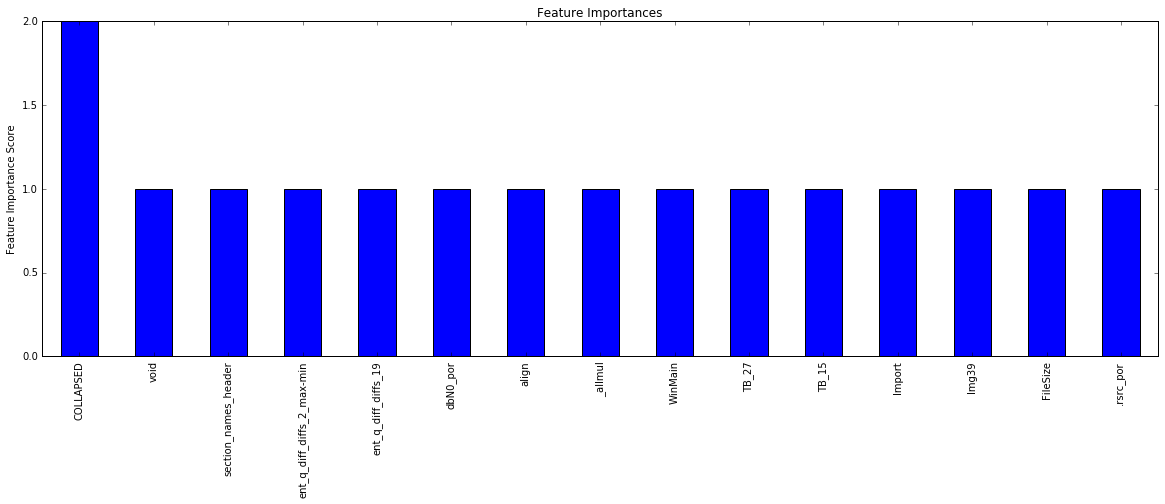

In [43]:
target='Class'
predictors = [x for x in train2.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train2, predictors)


Model Report
Accuracy : 0.9997
AUC Score (Train): 0.999796


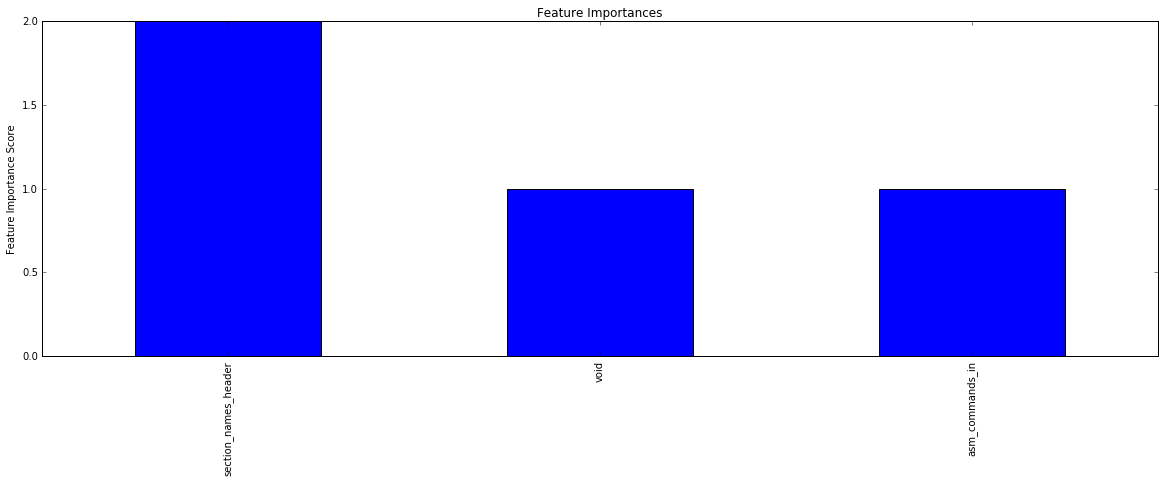

In [40]:
target='Class'
predictors = [x for x in train2.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.92,
 colsample_bytree=0.92,
 reg_alpha=1e-5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train2, predictors)